# Data Mining - Clustering Testing Group 5

# This notebook was developed by:

- Daniel Caridade (20211588)
- Gonçalo Teles (20211684)
- Gonçalo Peres (20211625)
- João Venichand (20211664)

# Table of Content

- [1. Importing Libraries](#1-importing-libraries)
- [2. Data Integration](#2-data-integration)
    - [2.1. Data Description](#21-data-description)
- [3. Additional Features Recreation](#3-additional-features-recreation)
- [4. Data Preprocessing](#4-data-preprocessing)
    - [4.1. Solving Incoherences](#41-solving-incoherences)
    - [4.2. Feature Engineering](#42-feature-engineering)
    - [4.3. Handling Missing Values](#43-handling-missing-values)
    - [4.4. Outliers](#44-outliers)
- [5. Feature Selection](#5-feature-selection)
- [6. Clustering](#6-clustering)
    - [6.1. Customer Activity Perspective](#61-customer-activity-perspective)
        - [6.1.1. Using KMeans](#611-using-kmeans)
        - [6.1.2. Using Hierarchical Clustering](#612-using-hierarchical-clustering)
        - [6.1.3. Visualizing the Clustering Solution](#613-visualizing-the-clustering-solution)
    - [6.2. Cuisine Preferences Perspective](#62-cuisine-preferences-perspective)
        - [6.2.1. Using KMeans](#621-using-kmeans)
        - [6.2.2. Using Hierarchical Clustering](#622-using-hierarchical-clustering)
        - [6.2.3. Final Solution Visualization](#623-final-solution-visualization)


# 1. Importing libraries

__`Step 1`__ Import the required libraries.

In [1]:
# EDA
import pandas as pd 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import os
import warnings

# Pre-processing
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from scipy.stats import johnsonsu



# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from tabulate import tabulate

# Profilling
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

# 2. Data Integration

__`Step 2`__ Use the method **.read_csv()** to import the dataset, storing it in the data frame **data** and checking the top 5 rows with the  **.head()** method.

In [2]:
data = pd.read_csv('C:/Users/danie/Downloads/NOVA IMS/Masters - Data Science and Advanced Analytics/1st year/1st semester/Data Mining/Project/Part 2/DM2425_ABCDEats_DATASET.csv')
data.head()

customer_id customer_region  customer_age  vendor_count  product_count  \
0  1b8f824d5e            2360          18.0             2              5   
1  5d272b9dcb            8670          17.0             2              2   
2  f6d1b2ba63            4660          38.0             1              2   
3  180c632ed8            4660           NaN             2              3   
4  4eb37a6705            4660          20.0             2              5   

   is_chain  first_order  last_order last_promo payment_method  ...  HR_14  \
0         1          0.0           1   DELIVERY           DIGI  ...      0   
1         2          0.0           1   DISCOUNT           DIGI  ...      0   
2         2          0.0           1   DISCOUNT           CASH  ...      0   
3         1          0.0           2   DELIVERY           DIGI  ...      1   
4         0          0.0           2          -           DIGI  ...      0   

   HR_15  HR_16  HR_17  HR_18  HR_19  HR_20  HR_21  HR_22  HR_23  
0      0      0      0      2      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0  

[5 rows x 56 columns]

__`Step 2.1`__ Create a copy of the data dataframe called **df**.

In [3]:
df = data.copy()

- We will use the dataframe **data** as a static representation of the the original dataset. This allows us to continuously monitor the percentage of data removed, ensuring it does not exceed the commonly accepted threshold of 5% (rule of thumb).
- The dataframe **df** will be the one that will suffer all the transformations through the Data Preprocessing stage.

__`Step 3`__ Setting `customer_id` as index.

In [4]:
df.set_index('customer_id', inplace=True)
df.head()

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
1b8f824d5e             2360          18.0             2              5   
5d272b9dcb             8670          17.0             2              2   
f6d1b2ba63             4660          38.0             1              2   
180c632ed8             4660           NaN             2              3   
4eb37a6705             4660          20.0             2              5   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
1b8f824d5e          1          0.0           1   DELIVERY           DIGI   
5d272b9dcb          2          0.0           1   DISCOUNT           DIGI   
f6d1b2ba63          2          0.0           1   DISCOUNT           CASH   
180c632ed8          1          0.0           2   DELIVERY           DIGI   
4eb37a6705          0          0.0           2          -           DIGI   

             CUI_American  ...  HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  \
customer_id                ...                                             
1b8f824d5e           0.00  ...      0      0      0      0      2      0   
5d272b9dcb          12.82  ...      0      0      0      0      0      0   
f6d1b2ba63           9.20  ...      0      0      0      0      0      0   
180c632ed8           0.00  ...      1      0      0      0      0      0   
4eb37a6705          14.57  ...      0      0      0      0      0      0   

             HR_20  HR_21  HR_22  HR_23  
customer_id                              
1b8f824d5e       0      0      0      0  
5d272b9dcb       0      0      0      0  
f6d1b2ba63       0      0      0      0  
180c632ed8       0      0      0      0  
4eb37a6705       0      0      0      0  

[5 rows x 55 columns]

## 2.1 Data Description

`customer_id:` Unique identifier for each customer. <br>
`customer_region:` Geographic region where the customer is located. <br>
`customer_age:` Age of the customer. <br>
`vendor_count:` Number of unique vendors the customer has ordered from. <br>
`product_count:` Total number of products the customer has ordered. <br>
`is_chain:` Indicates whether the customer’s order was from a chain restaurant. <br>
`first_order:` Number of days from the start of the dataset when the customer first placed an order. <br>
`last_order:` Number of days from the start of the dataset when the customer most recently placed an order. <br>
`last_promo:` The category of the promotion or discount most recently used by the customer. <br>
`payment_method:` Method most recently used by the customer to pay for their orders. <br>
`CUI_American, CUI_Asian, CUI_Chinese, CUI_Italian, etc:` The amount in monetary units spent by the customer from the indicated type of cuisine. <br>
`DOW_0 to DOW_6:` Number of orders placed on each day of the week (0 = Sunday, 6 = Saturday). <br>
`HR_0 to HR_23:` Number of orders placed during each hour of the day (0 = midnight, 23 = 11 PM).

# 3. Additional Features Recreation

__`Step 4`__ Create the additional features explored in the EDA.

In [5]:
# Create feature D_orders
df['D_orders'] = df[['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6']].sum(axis=1)

# Create feature H_orders
df['H_orders'] = df[['HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 
                    'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23']].sum(axis=1)

# Create feature Orders_Weekday
df['Orders_Weekday'] = df[['DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5']].sum(axis=1)

# Create feature Orders_Weekend
df['Orders_Weekend'] = df[['DOW_0', 'DOW_6']].sum(axis=1)

# Create feature Early_Morning
df['Early_Morning'] = df[['HR_5', 'HR_6', 'HR_7', 'HR_8']].sum(axis=1)

# Create feature Morning
df['Morning'] = df[['HR_9', 'HR_10', 'HR_11']].sum(axis=1)

# Create feature Afternoon
df['Afternoon'] = df[['HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16']].sum(axis=1)

# Create feature Evening 
df['Evening'] = df[['HR_17', 'HR_18', 'HR_19', 'HR_20']].sum(axis=1)

# Create feature Night
df['Night'] = df[['HR_21', 'HR_22', 'HR_23', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4']].sum(axis=1)

# Create feature dayswus
df['dayswus'] = df['last_order'].max() - df['first_order']

# Create feature recency
df['recency'] = df['last_order'].max() - df['last_order']

# 4. Data Preprocessing 

## 4.1. Solving incoherences

__`Step 5`__ Remove duplicated rows from the dataset.

In [6]:
# Drop the duplicates in the df
df.drop_duplicates(inplace=True)
# Print the current number of duplicates in df to if the code worked
df.duplicated().sum()

0

__`Step 6`__ Changing the values in variable `customer_region` that are equal to "-" into Unknown.

In [7]:
# Applying the transformation
df['customer_region'] = df['customer_region'].replace('-', 'UNKNOWN')

__`Step 6.1`__ Cheecking if there are customers that have a value of `is_chain` that only belongs to people from region **2360**.

In [8]:
# List of is_chain values for which we want to check the condition
chain_list = [36, 37, 38, 39, 40, 42, 44, 46, 47, 49, 54, 56, 61, 63, 65, 67, 73, 75, 80, 81, 83]

# Printing the number of rows that have missing value but have the same is_chain value as people from region 2360
len(df[(df['is_chain'].isin(chain_list)) & (df['customer_region'] == 'Unknown')])

0

- There are no customers from the **Unknown** region group who are clearly identified as customers from the **2360** region. 
- However, it is still possible that they belong to that region, as individuals with values different from those in *`is_chain`* may also be part of that region.


__`Step 7`__ Changing the values in variable `last_promo` that are equal to "-" into the string "NONE".

In [9]:
# Applying the transformation
df['last_promo'] = df['last_promo'].replace('-', 'NONE')

# Counting the occurrences of each unique value in the 'last_promo' column to check if the transformation was done properly
df['last_promo'].value_counts(normalize=True)

last_promo
NONE        0.525386
DELIVERY    0.197028
DISCOUNT    0.141102
FREEBIE     0.136484
Name: proportion, dtype: float64

__`Step 8`__ Creating lists that aggregate the columns regarding cuisine, orders by day of the week and orders by hour of the day.

In [10]:
# Create cuisine_columns that stores all columns regarding cuisine
cuisine_columns = ["CUI_American", "CUI_Asian", "CUI_Beverages", "CUI_Cafe", "CUI_Chicken Dishes", "CUI_Chinese", "CUI_Desserts", "CUI_Healthy", 
                   "CUI_Indian", "CUI_Italian", "CUI_Japanese", "CUI_Noodle Dishes", "CUI_OTHER", "CUI_Street Food / Snacks", "CUI_Thai"]
# Create dow_columns that stores all columns regarding orders by day of the week
dow_columns = ["DOW_0", "DOW_1", "DOW_2", "DOW_3", "DOW_4", "DOW_5", "DOW_6"]

# Create hr_columns that store all columns regarding orders by hour of the day
hr_columns = ["HR_" + str(i) for i in range(24)]

# Create all_columns 
all_columns = cuisine_columns + dow_columns + hr_columns

- The primary purpose of creating these lists is to simplify accessing specific columns in the dataset.  
  By using these lists, we can avoid repeatedly typing out column names, making the code cleaner and more efficient.



__`Step 9`__ Deleting customers that did not make any purchase nor spent any money in the company.

In [11]:
# Deleting the rows with non-customers
df = df[~(df[all_columns] == 0).all(axis=1)]

# Checking if there are no more incoherences in the dataset (rows where all values are 0)
len(df[(df[all_columns] == 0).all(axis=1)])

0

__`Step 10`__ Subsetting our data frame to only include customers that have at least 16 years old. 

In [12]:
df = df[df['customer_age'] >= 16]

__`Step 11`__ Replacing all values in rows where `product_count` is 0 with NaN.

In [13]:
# Replace all values in rows where 'product_count' is 0 with NaN
df.loc[df['product_count'] == 0, 'product_count'] = np.nan

## 4.2. Feature Engineering

__`Step 12`__ Create 2 functions for ploting heatmaps of the correlation matrix.

In [14]:
# This functions purpose is to plot the heatmap of the entire correlation matrix.
def cor_heatmap(cor):
    plt.figure(figsize=(40,40))
    sns.heatmap(data = cor, annot = True, cmap = "coolwarm", fmt='.1')
    plt.show()

# This functions purpose is to plot the heatmap of the entire correlation matrix, but only displaying values of correlation above 0.8.
def cor_heatmap1(cor, threshold=0.8):
    # Create a mask that displays only correlations above the threshold
    annot = np.where((cor >= threshold) | (cor <= -threshold), cor.round(2), "")  # Round numeric values
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(data=cor, annot=annot, cmap="coolwarm", center=0, linewidths=0.5, linecolor='black',
                cbar_kws={'shrink': 0.75}, annot_kws={"size": 10}, fmt='')  # Empty format for mixed strings and floats
    plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for clarity
    plt.yticks(rotation=0)  # Ensuring y-axis labels are horizontal
    plt.savefig("heatmap.png", bbox_inches='tight', dpi=300)  # Save the plot
    plt.show()

__`Step 12.1`__ Checking the correlation on cuisine features.

In [15]:
CUI_cor_spearman = df[cuisine_columns].corr(method = 'spearman')
cor_heatmap(CUI_cor_spearman)

__`Step 13`__ Updating new feature `CUI_Chinese` to include `CUI_Chicken Dishes`.

In [16]:
df['CUI_Chinese'] = df[['CUI_Chinese', 'CUI_Chicken Dishes']].sum(axis=1)

__`Step 13.1`__ Creating a new feature `CUI_IndianOceanic` that aggregates `CUI_India` and `CUI_Thai`.

In [17]:
df['CUI_IndianOceanic'] = df[['CUI_Indian', 'CUI_Thai']].sum(axis=1)

__`Step 13.2`__ Create feature `CUI_Western` that aggregates `CUI_American` and `CUI_Italian`.

In [18]:
df['CUI_Western'] = df[['CUI_American', 'CUI_Italian']].sum(axis=1)

__`Step 13.3`__ Create feature `CUI_Street_Food_Beverages` that aggregates the values in `CUI_Street Food / Snacks` and `CUI_Beverages`.

In [19]:
df['CUI_Street_Food_Beverages'] = df[['CUI_Street Food / Snacks', 'CUI_Beverages']].sum(axis=1)

**Aggregation of Cuisine Features**

The aggregation of features related to cuisine was performed not only based on logical grouping but also with careful consideration of the relationships among the features being aggregated. Specifically, aggregated features do not include individual features that have different types of relationships with each other. 

For example, in **`CUI_IndianOceanic`**, all the individual features combined to create this aggregated feature exhibit positive relationships with each other, ensuring consistency within the aggregation.

---

**Why Is This Approach Valid?**

This method ensures that:
1. **Logical Consistency**: Aggregated features represent coherent groups where the relationships among components reinforce the overall meaning of the feature.
2. **Avoidance of Misleading Results**: Mixing features with conflicting relationships (e.g., one feature positively correlated while another is negatively correlated) could lead to misleading or non-intuitive results during analysis.
3. **Enhanced Interpretability**: By ensuring that features aggregated into a single group behave similarly, the resulting feature is more interpretable and meaningful for clustering.


__`Step 14`__ Create a list named `var_freq_enc` that stores the features that will encoded through frequency encoding.

In [20]:
var_freq_enc = ['last_promo', 'payment_method', 'customer_region']

__`Step 15`__ Define a function to perform frequency encoding and 2 others to revert the transformation.

In [21]:
# Define a function to perform frequency encoding
def frequency_encoding(df, columns):
    for column in columns:
        # Calculate the frequency of each category in the column
        freq_encoding = df[column].value_counts()
        # Replace categories with their corresponding frequencies
        df[column] = df[column].map(freq_encoding)
    
    return df

In [22]:
# Define function to store the original values
def store_original_values(df, column_names):
    """
    This function stores the original values in multiple columns along with their indices.
    
    Args:
    df: pandas DataFrame containing the data.
    column_names: List of column names to track original values and their indices.
    
    Returns:
    A dictionary where keys are column names, and values are dictionaries 
    of original values with their corresponding indices.
    """
    original_dict = {}

    # Iterate over each column
    for column_name in column_names:
        column_dict = {}
        for idx, value in enumerate(df[column_name]):
            if value not in column_dict:
                column_dict[value] = []
            column_dict[value].append(idx)
        original_dict[column_name] = column_dict
    
    return original_dict

# Store the original values in each row to reverse the transformation afterwards
original_values = store_original_values(df, var_freq_enc)

# Define function to restore the original values 
def restore_original_values(df, original_dict):
    """
    This function restores the original values in multiple columns using the original dictionary.
    
    Args:
    df: pandas DataFrame containing the data.
    original_dict: Dictionary with column names as keys and the original value dictionaries as values.
    
    Returns:
    A DataFrame with the columns restored to their original values.
    """
    # Create a copy of the DataFrame to avoid modifying the original one
    df_copy = df.copy()

    # Iterate over the dictionary and restore original values for each column
    for column_name, column_dict in original_dict.items():
        for value, indices in column_dict.items():
            for idx in indices:
                df_copy.at[idx, column_name] = value
    
    return df_copy

__`Step 15.1`__ Perform frequency encoding in the categorical features except `is_chain`.

In [23]:
frequency_encoding(df, var_freq_enc)

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                               
1b8f824d5e              8589          18.0             2            5.0   
5d272b9dcb              9386          17.0             2            2.0   
f6d1b2ba63              9313          38.0             1            2.0   
4eb37a6705              9313          20.0             2            5.0   
6aef2b6726              9386          40.0             2            2.0   
...                      ...           ...           ...            ...   
f2d4790b5b              9386          21.0             1            1.0   
f4e366c281              9386          30.0             1            1.0   
f74ad8ce3f              9386          24.0             1            1.0   
f7b19c0241              9386          34.0             1            1.0   
fd40d3b0e0              9313          30.0             1            1.0   

             is_chain  first_order  last_order  last_promo  payment_method  \
customer_id                                                                  
1b8f824d5e          1          0.0           1        6091            5902   
5d272b9dcb          2          0.0           1        4354            5902   
f6d1b2ba63          2          0.0           1        4354            5450   
4eb37a6705          0          0.0           2       16251            5902   
6aef2b6726          0          0.0           2        4247            5902   
...               ...          ...         ...         ...             ...   
f2d4790b5b          1          NaN           0        6091            5902   
f4e366c281          1          NaN           0        4247            5902   
f74ad8ce3f          1          NaN           0       16251            5902   
f7b19c0241          0          NaN           0        4354            5902   
fd40d3b0e0          0          NaN           0       16251            5450   

             CUI_American  ...  Early_Morning  Morning  Afternoon  Evening  \
customer_id                ...                                               
1b8f824d5e           0.00  ...              0        0          0        2   
5d272b9dcb          12.82  ...              0        2          0        0   
f6d1b2ba63           9.20  ...              0        2          0        0   
4eb37a6705          14.57  ...              1        1          0        0   
6aef2b6726           0.00  ...              0        0          0        0   
...                   ...  ...            ...      ...        ...      ...   
f2d4790b5b           0.00  ...              0        1          0        0   
f4e366c281           0.00  ...              0        0          1        0   
f74ad8ce3f           0.00  ...              1        0          0        0   
f7b19c0241           0.00  ...              0        1          0        0   
fd40d3b0e0           0.00  ...              0        0          1        0   

             Night  dayswus  recency  CUI_IndianOceanic  CUI_Western  \
customer_id                                                            
1b8f824d5e     0.0     90.0       89              28.88         0.00   
5d272b9dcb     0.0     90.0       89               0.00        12.82   
f6d1b2ba63     0.0     90.0       89               0.00         9.20   
4eb37a6705     0.0     90.0       88               0.00        14.57   
6aef2b6726     2.0     90.0       88               0.00         0.00   
...            ...      ...      ...                ...          ...   
f2d4790b5b     0.0      NaN       90               0.00         0.00   
f4e366c281     0.0      NaN       90               0.00         0.00   
f74ad8ce3f     0.0      NaN       90               0.00         0.00   
f7b19c0241     0.0      NaN       90               0.00         0.00   
fd40d3b0e0     0.0      NaN       90               0.00         7.91   

             CUI_Street_Food_Beverages  
customer_id                  

**Reasoning for frequency encoding**

- During the Exploratory Data Analysis (EDA), we observed that there are missing values in the dataset that need to be addressed. Most imputation techniques require categorical variables to be encoded as numerical features.

**Why Frequency Encoding?**

- Unlike methods such as OneHotEncoding, frequency encoding does not create additional features.
- It simplifies reconversion to the original categories, as each category is represented by its frequency value. This ensures the encoded features remain interpretable.
- Since we won’t directly use categorical features in clustering algorithms for the two perspectives we will analyze later, frequency encoding provides a compact and efficient encoding approach.

__`Step 16`__ Dropping variable `is_chain`.

In [24]:
df.drop('is_chain', axis=1, inplace=True)

**Reasons to Drop the `is_chain` Variable**

- Due to an inconsistency observed between the metadata and the values in the `is_chain` column, we have decided to remove this variable from the analysis. Furthermore, analysis shows that **71%** of the customers have a value in the `is_chain` column between 0 and 3, indicating a high level of redundancy in the data.
- Even if we were to treat this feature as binary (with 0 for `is_chain` values of 0 and 1 for all other values), it would likely dominate the importance in any clustering algorithm. This is because such a binary transformation would result in the feature either having the minimum or maximum distance, creating an artificial distinction that would skew the clustering process.
- Given that we already have a sufficient set of features that enable us to effectively segment customers, dropping the `is_chain` variable will not significantly impact the model's performance. This decision helps streamline the dataset and avoids introducing potential bias in the clustering algorithms.

## 4.3. Handling Missing Values

__`Step 17`__ Imputing missing values in column `HR_0` as the difference between the values in columns `D_orders` and `H_orders`.

In [25]:
# Calculating the difference where HR_0 is missing
df.loc[df['HR_0'].isnull(), 'HR_0'] = df['D_orders'] - df['H_orders']

# Verifying the changes
missing_hr0_after = df['HR_0'].isnull().sum()
print(f"Number of missing values in 'HR_0' after substitution: {missing_hr0_after}")

Number of missing values in 'HR_0' after substitution: 0


__`Step 17.1`__ Recalculating `H_orders` and `Nights` and checking if the values in `D_orders` and `H_orders` match as they should.

In [26]:
# Recalculating 'H_orders' after updating 'HR_0'
df['H_orders'] = df[['HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 
                         'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 
                         'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 
                         'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23']].sum(axis=1)

# Recalculating 'Night' after updating 'HR_0'
df['Night'] = df[['HR_21', 'HR_22', 'HR_23', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4']].sum(axis=1) 

# Comparing 'T_orders' and 'H_orders' to see if they are equal
are_equal_after_recalculation = (df['D_orders'] == df['H_orders']).all()

if are_equal_after_recalculation:
    print("All values in 'D_orders' and 'H_orders' are equal after recalculation.")
else:
    print("There are still differences between 'T_orders' and 'H_orders' after recalculation.")

All values in 'D_orders' and 'H_orders' are equal after recalculation.


__`Step 18`__ Remove all unecessary features from the dataset.

In [27]:
columns_to_drop = ['CUI_Beverages', 'CUI_Chicken Dishes', 'CUI_Indian', 'CUI_Thai', 'CUI_American','CUI_Italian', 'CUI_Street Food / Snacks', 
                   'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_0', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 
                   'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 
                   'HR_22', 'HR_23', 'D_orders', 'H_orders']

df.drop(columns_to_drop, axis=1, inplace=True)

**Feature Removal Rationale**

1. **`HR_` and `DOW_` Features**  
   The `HR_` and `DOW_` features were removed because we created aggregated features that effectively capture the same information while reducing dimensionality. This approach simplifies the dataset and improves computational efficiency.

2. **Cuisine Features (`CUI_Beverages`, `CUI_Chicken Dishes`, `CUI_Indian`, `CUI_Thai`, `CUI_American`, `CUI_Italian`, `CUI_Street Food / Snacks`)**  
   These features were removed as they were aggregated into higher-level features. This aggregation not only reduces redundancy but also creates more robust variables that encapsulate broader trends.

3. **`D_Orders` and `H_Orders` Features**  
   The `D_Orders` and `H_Orders` features were dropped because they represent a high level of aggregation. Instead, we retained features with lower levels of aggregation, which provide more granular and useful information for analysis. However, `D_Orders` and `H_Orders` served their purpose by helping to resolve missing values in the `HR_0` feature before being removed.


__`Step 19`__ Imputing values in `first_order` as 0 if the value in the `last_order` equals 0.

In [28]:
df.loc[(df['last_order'] == 0) & (df['first_order'].isna()), 'first_order'] = 0

__`Step 20`__ Scaling the data to be able to make imputation through K-Nearest Neighbours.

In [29]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_df = scaler.fit_transform(df)

# Convert the result back to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

__`Step 20.1`__ Performing imputation of the remaining missing values through KNN with 5 clusters.

In [30]:
# Define the columns you want to impute
columns_to_imput = ['customer_age', 'first_order', 'product_count']

# Initialize the KNN imputer (you can set the number of neighbors, e.g., n_neighbors=5)
knn_imputer = KNNImputer(n_neighbors=5)

# Perform the KNN imputation on the specified columns
scaled_df[columns_to_imput] = knn_imputer.fit_transform(scaled_df[columns_to_imput])

__`Step 20.2`__ Recalculate column `dayswus`.

In [31]:
scaled_df['dayswus'] = scaled_df['last_order'].max() - scaled_df['first_order']

__`Step 20.3`__ Checking if there are remaining missing values that need to be imputted.

In [32]:
scaled_df.isna().sum()

customer_region              0
customer_age                 0
vendor_count                 0
product_count                0
first_order                  0
last_order                   0
last_promo                   0
payment_method               0
CUI_Asian                    0
CUI_Cafe                     0
CUI_Chinese                  0
CUI_Desserts                 0
CUI_Healthy                  0
CUI_Japanese                 0
CUI_Noodle Dishes            0
CUI_OTHER                    0
Orders_Weekday               0
Orders_Weekend               0
Early_Morning                0
Morning                      0
Afternoon                    0
Evening                      0
Night                        0
dayswus                      0
recency                      0
CUI_IndianOceanic            0
CUI_Western                  0
CUI_Street_Food_Beverages    0
dtype: int64

__`Step 20.4`__ Check the percentage of the original dataset that already was removed.

In [33]:
print(f'{round((1 - (scaled_df.shape[0] / data.shape[0])) * 100, 2)}% of the original dataset has been removed so far.')

2.96% of the original dataset has been removed so far.


__`Step 20.5`__ Reversing  the frequency encoding previously done.

In [34]:
scaled_df = restore_original_values(scaled_df, original_values)

C:\Users\danie\AppData\Local\Temp\ipykernel_10712\2387521456.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DELIVERY' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.at[idx, column_name] = value
C:\Users\danie\AppData\Local\Temp\ipykernel_10712\2387521456.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DIGI' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.at[idx, column_name] = value
C:\Users\danie\AppData\Local\Temp\ipykernel_10712\2387521456.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2360' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.at[idx, column_name] = value


__`Step 20.6`__ Checking if the columns were corretly reconverted.

In [ ]:
print(f"{scaled_df['payment_method'].value_counts()}\n")
print(f"{scaled_df['last_promo'].value_counts()}\n")
print(f"{scaled_df['customer_region'].value_counts()}")

payment_method
CARD    19591
DIGI     5902
CASH     5450
Name: count, dtype: int64

last_promo
NONE        16251
DELIVERY     6091
DISCOUNT     4354
FREEBIE      4247
Name: count, dtype: int64

customer_region
8670       9386
4660       9313
2360       8589
2440       1448
4140        834
8370        483
UNKNOWN     440
2490        437
8550         13
Name: count, dtype: int64


## 4.4. Outliers

__`Step 21`__ Recreating the list `cuisines_columns` so that it incompasses all the columns with information about cuisines that were kept.

In [36]:
cuisine_columns = ['CUI_Asian', 'CUI_Cafe', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER',
                  'CUI_IndianOceanic', 'CUI_Western', 'CUI_Street_Food_Beverages']

__`Step 21.1`__ Check the outliers in the columns regarding cuisine.

In [37]:
# Ignore all warnings
warnings.filterwarnings('ignore')

# Set Seaborn style to white
sns.set_style('white')

# Define the grid size
num_cols = 3  # Number of columns in the grid
num_rows = -(-len(cuisine_columns) // num_cols)  # Calculate rows needed (ceil division)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten axes for easy iteration

# Create boxplots
for i, column in enumerate(cuisine_columns):
    sns.boxplot(data=scaled_df, y=column, ax=axes[i], color="skyblue")
    axes[i].set_title(column, fontsize=12)
    axes[i].set_ylabel('')  # Remove ylabel for a cleaner look

# Remove empty subplots
for j in range(len(cuisine_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout()
plt.show()

__`Step 21.2`__ Removing the most extreme outliers from the dataset.

In [38]:
scaled_df = scaled_df[scaled_df['CUI_Asian'] < 35]
scaled_df = scaled_df[scaled_df['CUI_Cafe'] < 50]
scaled_df = scaled_df[scaled_df['CUI_Chinese'] < 80]
scaled_df = scaled_df[scaled_df['CUI_Desserts'] < 40]
scaled_df = scaled_df[scaled_df['CUI_Healthy'] < 40]
scaled_df = scaled_df[scaled_df['CUI_Japanese'] < 70]
scaled_df = scaled_df[scaled_df['CUI_Noodle Dishes'] < 60]
scaled_df = scaled_df[scaled_df['CUI_IndianOceanic'] < 35]
scaled_df = scaled_df[scaled_df['CUI_Western'] < 25]
scaled_df = scaled_df[scaled_df['CUI_Street_Food_Beverages'] < 25]

__`Step 21.3`__ Check the percentage of the original dataset that already was removed.

In [39]:
print(f'{round((1 - (scaled_df.shape[0] / data.shape[0])) * 100, 2)}% of the original dataset has been removed so far.')

2.99% of the original dataset has been removed so far.


__`Step 22`__ Recreating lists `dow_columns` and `hr_columns` to accomodate the columns that remained in the dataset.` 

In [40]:
dow_columns = ['Orders_Weekday', 'Orders_Weekend']

hr_columns = ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night']

__`Step 22.1`__ Plot the boxplot of the `dow_columns`.

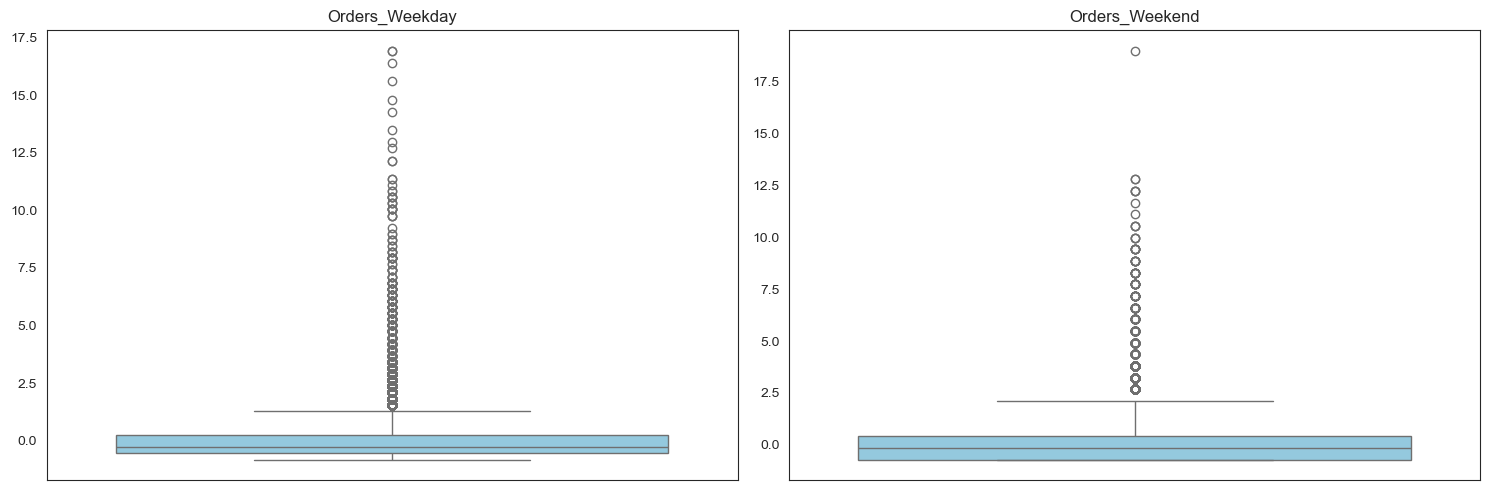

In [41]:
# Ignore all warnings
warnings.filterwarnings('ignore')

# Set Seaborn style to white
sns.set_style('white')

# Define the grid size
num_cols = 2
num_rows = 1  

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))
axes = axes.flatten()  # Flatten axes for easy iteration

# Create boxplots
for i, column in enumerate(dow_columns):
    sns.boxplot(data=scaled_df, y=column, ax=axes[i], color="skyblue")
    axes[i].set_title(column, fontsize=12)
    axes[i].set_ylabel('')

# Adjust layout
fig.tight_layout()
plt.show()

__`Step 22.2`__ Plot the boxplot of the `hr_columns`.

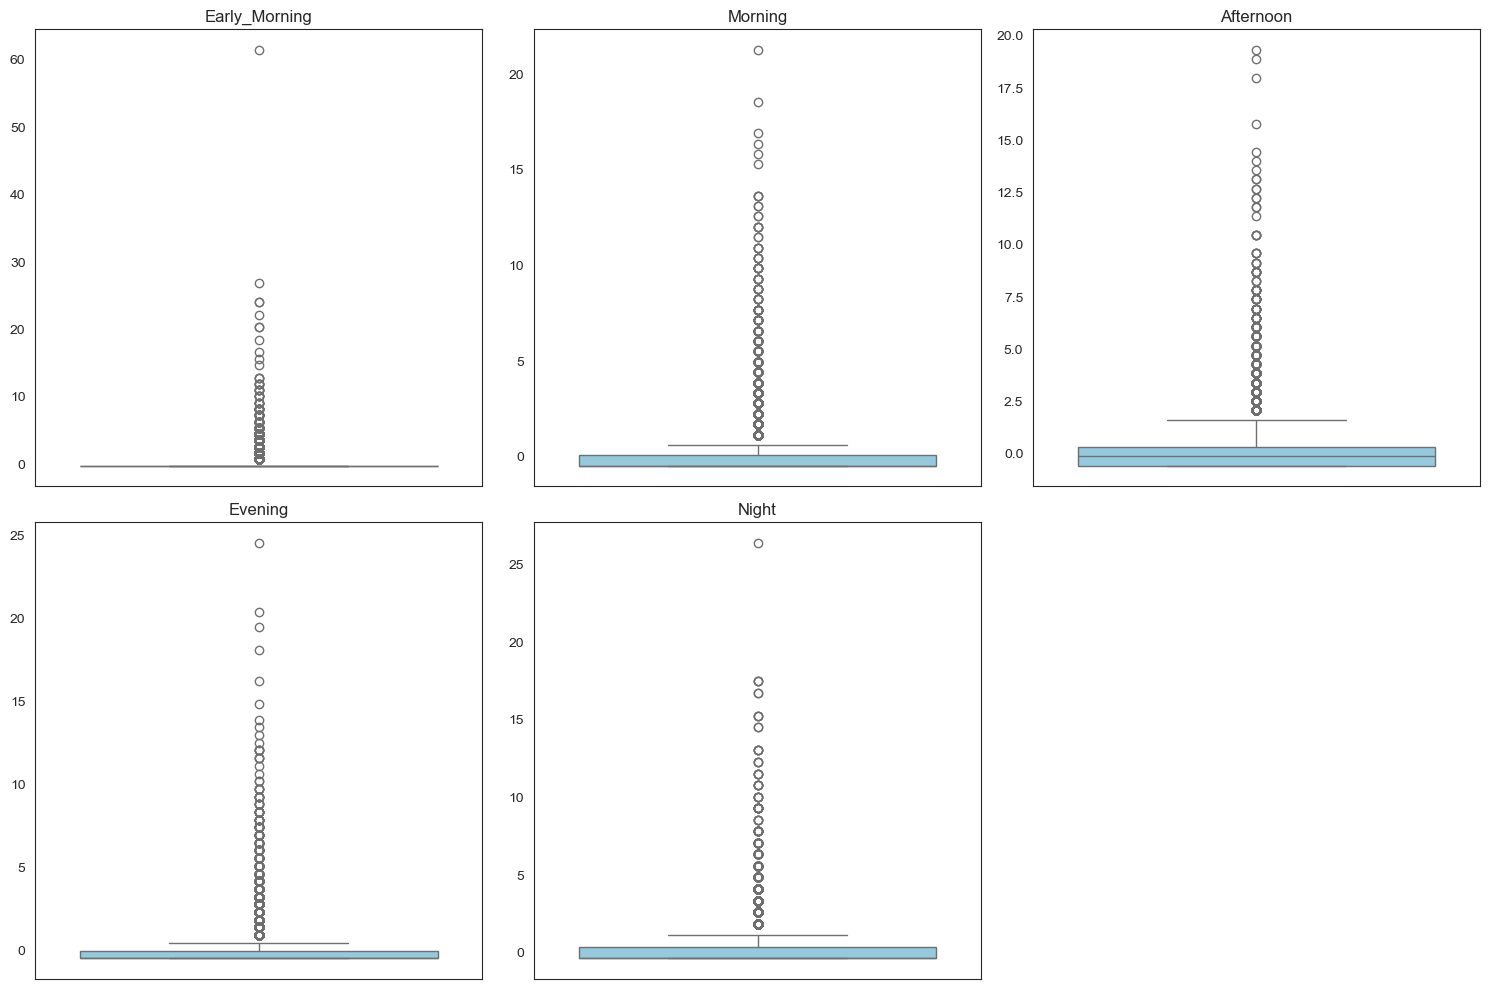

In [42]:
# Ignore all warnings
warnings.filterwarnings('ignore')

# Set Seaborn style to white
sns.set_style('white')

# Define the grid size
num_cols = 3
num_rows = -(-len(hr_columns) // num_cols)  # Calculate rows needed (ceil division)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5)) 
axes = axes.flatten()  # Flatten axes for easy iteration

# Create boxplots
for i, column in enumerate(hr_columns):
    sns.boxplot(data=scaled_df, y=column, ax=axes[i], color="skyblue")
    axes[i].set_title(column, fontsize=12)
    axes[i].set_ylabel('')  # Remove ylabel for a cleaner look

# Remove empty subplots (if any)
for j in range(len(hr_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout()
plt.show()

__`Step 22.3`__ Removing the most extreme outliers.

In [43]:
scaled_df = scaled_df[scaled_df['Early_Morning'] < 60]
scaled_df = scaled_df[scaled_df['Morning'] < 20]
scaled_df = scaled_df[scaled_df['Evening'] < 22]
scaled_df = scaled_df[scaled_df['Night'] < 20]

__`Step 22.4`__ Check the percentage of rows that were removed.

In [44]:
print(f'{round((1 - (scaled_df.shape[0] / data.shape[0])) * 100, 2)}% of the original dataset has been removed so far.')

3.0% of the original dataset has been removed so far.


**Decisions regarding outlier removal**

- The majority of our features contain numerous outliers. Removing all of them would significantly alter the data distribution, effectively changing the underlying reality it represents. Therefore, we have chosen to remove only the most extreme outliers to maintain the integrity of the data.
- We decided to remove outliers from the `cuisines_columns` and `hr_columns` as these will be used in the two perspectives discussed in Section 6. Since the clustering algorithms will operate on these columns and are sensitive to outliers, addressing them is essential.
- In the end of outlier removal we concluded that only **3%** of the dataset was removed which is below the **5%** threshold previously mentioned.

# 5. Feature Selection

__`Step 23`__ Creating a list with the numerical and the categorical features.

In [45]:
# List of numerical features
numerical_features = ['customer_age', 'vendor_count', 'product_count', 'first_order', 'last_order', 'CUI_Asian', 'CUI_Cafe', 'CUI_Chinese', 
                      'CUI_Noodle Dishes', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Japanese', 'CUI_OTHER', 'CUI_IndianOceanic', 'CUI_Western', 
                      'CUI_Street_Food_Beverages', 'Orders_Weekday', 'Orders_Weekend', 'Early_Morning', 'Morning', 'Afternoon', 'Evening', 
                      'Night', 'dayswus', 'recency']

# List of categorical features
categorical_features = ['last_promo', 'payment_method', 'customer_region']


__`Step 24`__ Checking the variance of the variables.

In [ ]:
scaled_df[numerical_features].var()

customer_age                 1.000234
vendor_count                 0.995759
product_count                0.969973
first_order                  1.000009
last_order                   1.000067
CUI_Asian                    0.945342
CUI_Cafe                     0.917073
CUI_Chinese                  0.999685
CUI_Noodle Dishes            0.881617
CUI_Desserts                 0.938123
CUI_Healthy                  0.883870
CUI_Japanese                 0.996414
CUI_OTHER                    0.996845
CUI_IndianOceanic            0.999266
CUI_Western                  0.976483
CUI_Street_Food_Beverages    0.972360
Orders_Weekday               0.975132
Orders_Weekend               0.978861
Early_Morning                0.874733
Morning                      0.972554
Afternoon                    0.982766
Evening                      0.978388
Night                        0.975692
dayswus                      1.000009
recency                      1.000067
dtype: float64

__`Step 25`__ Checking the correlation between numerical features.

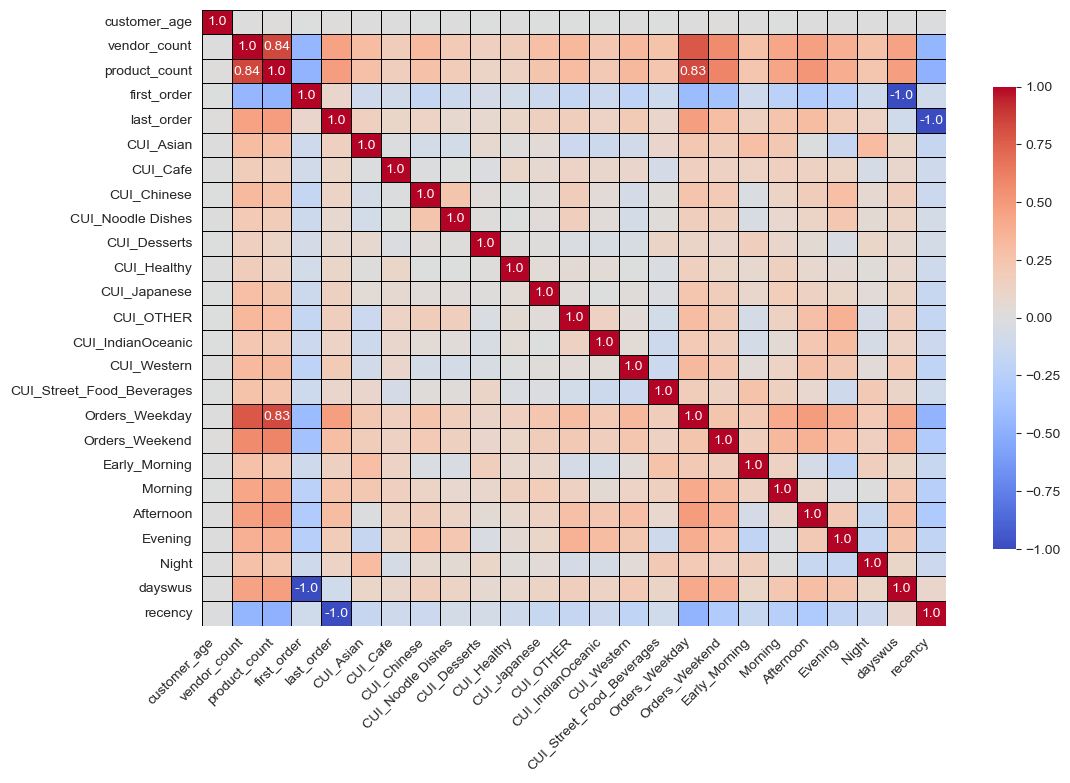

In [47]:
cor_spearman = scaled_df[numerical_features].corr(method='spearman')
cor_heatmap1(cor_spearman)

**Redundant and Relevant features**

**Predictor**              | **Variance** | **Spearman** | **Conclusion**
---------------------------|--------------|--------------|------------------------
customer_age               | Keep         | Keep         | Relevant feature
vendor_count               | Keep         | Keep         | Relevant feature
product_count              | Keep         | Discard      | Redundant feature (Drop)
first_order                | Keep         | Discard      | Redundant feature (Drop)
last_order                 | Keep         | Discard      | Redundant feature (Drop)
CUI_Asian                  | Keep         | Keep         | Relevant feature
CUI_Cafe                   | Keep         | Keep         | Relevant feature
CUI_Chinese                | Keep         | Keep         | Relevant feature
CUI_Desserts               | Keep         | Keep         | Relevant feature
CUI_Healthy                | Keep         | Keep         | Relevant feature
CUI_Japanese               | Keep         | Keep         | Relevant feature
CUI_Noodle Dishes          | Keep         | Keep         | Relevant feature
CUI_Other                  | Keep         | Keep         | Relevant feature
CUI_IndianOceanic          | Keep         | Keep         | Relevant feature
CUI_Western                | Keep         | Keep         | Relevant feature
CUI_Street_Food_Beverages  | Keep         | Keep         | Relevant feature
Orders_Weekday             | Keep         | Keep         | Relevant feature
Orders_Weekend             | Keep         | Keep         | Relevant feature
Early_Morning              | Keep         | Keep         | Relevant feature
Morning                    | Keep         | Keep         | Relevant feature
Afternoon                  | Keep         | Keep         | Relevant feature
Evening                    | Keep         | Keep         | Relevant feature
Night                      | Keep         | Keep         | Relevant feature
dayswus                    | Keep         | Keep         | Relevant feature
recency                    | Keep         | Keep         | Relevant feature

__`Step 26`__ Drop the redundant features from the dataset.

In [48]:
scaled_df.drop(['product_count', 'first_order', 'last_order'], axis=1, inplace=True)

# Updating list numeric features to remove those three columns 
numerical_features = [col for col in numerical_features if col not in ['product_count', 'first_order', 'last_order']]

# 6. Clustering

__`Step 27`__ Divide the columns of the dataset into 2 different perspectives: `cuisine_preferences` and `customer_activity`.

In [49]:
customer_activity = ['Orders_Weekday', 'Orders_Weekend', 'Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'dayswus', 'recency']

cuisine_preferences = ['CUI_Asian', 'CUI_Cafe', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 
                       'CUI_IndianOceanic', 'CUI_Western', 'CUI_Street_Food_Beverages']

After performing Clustering for the different customer profiles I just need to pick the centroids and do the clustering of them.

## 6.1. Customer Activity Perspective

__`Step 28`__ Create a dataframe called `perspective1` that is a subset of our dataframe with the columns in list `customer_activity`.

In [50]:
perspective1 = scaled_df[customer_activity]

# Checking the number of rows and columns from the new created dataframe
perspective1.shape

(30931, 9)

### 6.1.1 Using KMeans

__`Step 29`__ Visualise the within-cluster sum of squares (WSS) for different cluster amounts of `perspective1` to determine the optimal amount of clusters for our data, also known as the elbow method

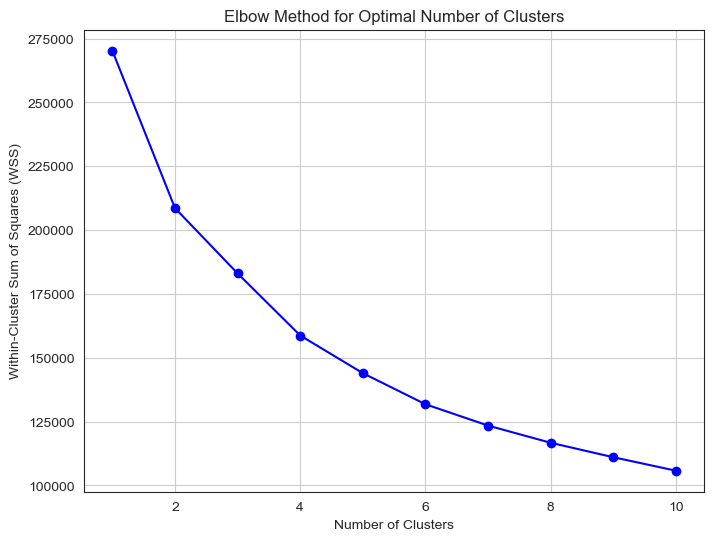

In [51]:
def plot_elbow_graph(data, max_clusters=10):
    # List to store the WSS (Within-Cluster Sum of Squares)
    wss = []
    
    # Iterate through a range of clusters
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=15, random_state = 90)
        kmeans.fit(data)
        wss.append(kmeans.inertia_)
    
    # Plot the elbow graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters+1), wss, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WSS)')
    plt.grid(True)
    plt.show()

plot_elbow_graph(perspective1)

- There is not a clear elbow in the image above but it seems closer to being 2 the elbow.

__`Step 30`__ Compute the average silhouette score to check what is the best number of clusters

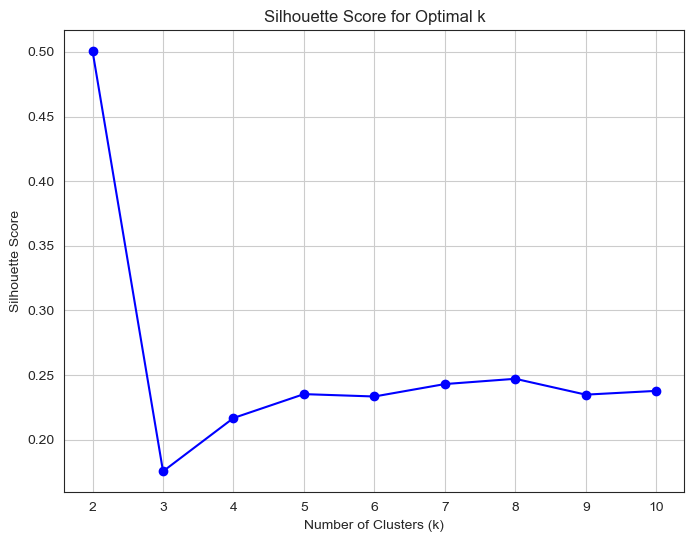

In [52]:
# Compute the silhouette score for a range of k values
sil_scores = []
for k in range(2,11): 
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=15, random_state=90)
    kmeans.fit(perspective1)
    sil_score = silhouette_score(perspective1, kmeans.labels_)
    sil_scores.append(sil_score)

# Plot the Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range(2,11), sil_scores, marker='o', color='b')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

**Choice in the number of clusters**

- Inertia (Scree Plot) - 2 clusters
- Silhouette score - 2 clusters

**Final Decision:** 2 clusters

__`Step 31`__ Perform the K-Means clustering with 2 clusters

In [53]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=15, random_state=90)
labels = kmeans.fit_predict(perspective1)

__`Step 31.1`__ Check the centroids of the clustering solution

In [ ]:
Centroids = pd.DataFrame(kmeans.cluster_centers_.round(2), columns=perspective1.columns)

# Print the DataFrame
print(tabulate(Centroids, headers='keys', tablefmt='pretty', showindex=True))
stats = Centroids.describe().iloc[[1,2,3,7]]
minmax_diff = stats.iloc[3]-stats.iloc[2]
stats.loc['minmax_differences'] = minmax_diff
print(stats)

+---+----------------+----------------+---------------+---------+-----------+---------+-------+---------+---------+
|   | Orders_Weekday | Orders_Weekend | Early_Morning | Morning | Afternoon | Evening | Night | dayswus | recency |
+---+----------------+----------------+---------------+---------+-----------+---------+-------+---------+---------+
| 0 |     -0.25      |     -0.22      |     -0.08     |  -0.17  |   -0.2    |  -0.18  | -0.08 |  1.03   |   0.1   |
| 1 |      2.04      |      1.83      |     0.64      |  1.41   |   1.61    |  1.45   | 0.64  |  1.98   |  -0.8   |
+---+----------------+----------------+---------------+---------+-----------+---------+-------+---------+---------+
                    Orders_Weekday  Orders_Weekend  Early_Morning   Morning  \
mean                      0.895000        0.805000       0.280000  0.620000   
std                       1.619275        1.449569       0.509117  1.117229   
min                      -0.250000       -0.220000      -0.080000 -

**Notes on this clustering solution**

- This solutions separates the customers into those that buy much and those that doesn't. 
- While it gives us a fairly high silhouette score this solutions lacks in differencing between different customers, for instance we can see that there are people that buy more than others, but we can't verify how they behave throughout the day our even throughout the week which is the main objective of this perspection.

**Overall this does not seems a very good clustering solution so further options will be considered.**

#### Testing Feature Normalization

__`Step 32`__ Create a copy of the first perspective.

In [55]:
perspective1_normalized = perspective1.copy()

__`Step 33`__  Applying the Johnson SU transformation to our perspective to transform features into a normal distribution

In [56]:
from scipy.stats import johnsonsu

# Function to apply the Johnson transformation to a single column
def johnson_transform(df):
    # We perform a Johnson SU transformation on the data
    param_estimates = johnsonsu.fit(df)  # Fit the distribution to the data (excluding NaN values)
    transformed_data = johnsonsu(*param_estimates).cdf(df)  # Apply the transformation (cumulative distribution function)
    return transformed_data

#Apply the Johnson transformation to all numeric columns
for column in perspective1_normalized.select_dtypes(include=[np.number]).columns:
    perspective1_normalized[column] = johnson_transform(perspective1_normalized[column])

__`Step 34`__ Visualise the within-cluster sum of squares (WSS) for different cluster amounts of `perspective1_normalized` to determine the optimal amount of clusters for our data, also known as the elbow method

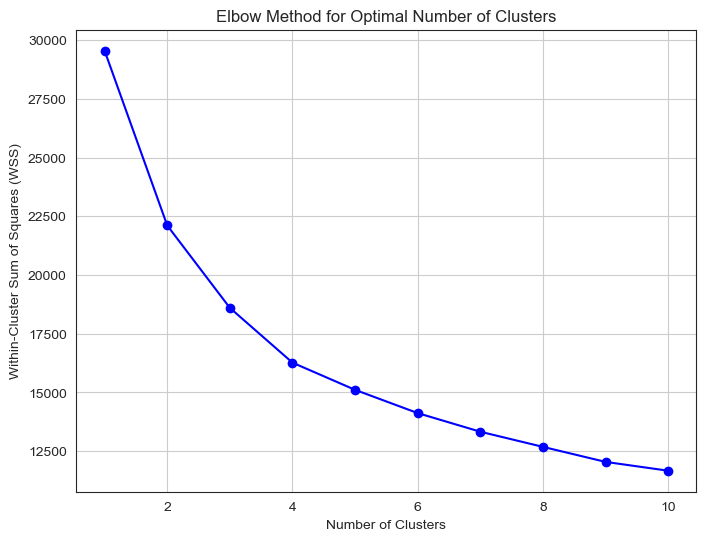

In [57]:
def plot_elbow_graph(data, max_clusters=10):
    # List to store the WSS (Within-Cluster Sum of Squares)
    wss = []
    
    # Iterate through a range of clusters
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=15, random_state = 90)
        kmeans.fit(data)
        wss.append(kmeans.inertia_)
    
    # Plot the elbow graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters+1), wss, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WSS)')
    plt.grid(True)
    plt.show()

plot_elbow_graph(perspective1_normalized)

- The elbow of this solution seems to lay between the 2 to 4 range.

__`Step 35`__ Use the average silhouette score to check what is the best clustering solution.

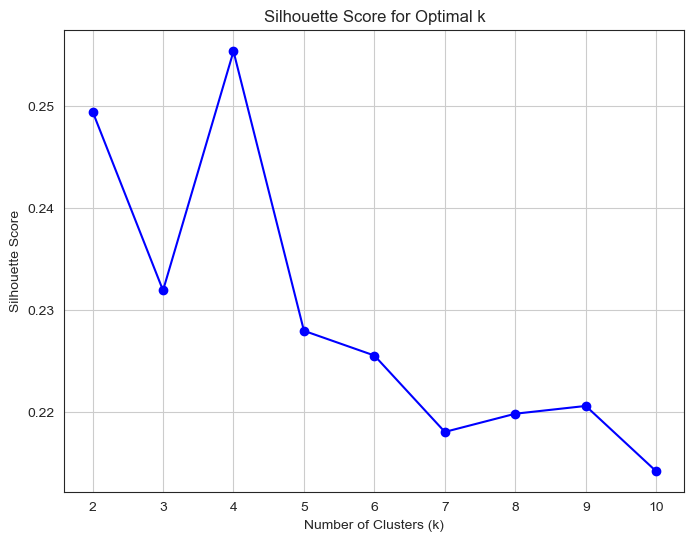

In [58]:
# Compute the silhouette score for a range of k values
sil_scores = []
for k in range(2,11): 
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=15, random_state=90)
    kmeans.fit(perspective1_normalized)
    sil_score = silhouette_score(perspective1_normalized, kmeans.labels_)
    sil_scores.append(sil_score)

# Plot the Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range(2,11), sil_scores, marker='o', color='b')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

**Choice in the number of clusters**

- Inertia (Scree Plot) - 2 to 4 clusters
- Silhouette score - 4 clusters

**Final Decision:** 4 clusters

__`Step 36`__ Create the clustering solution with 4 clusters.

In [59]:
k = 4
# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=90)
labels2 = kmeans.fit_predict(perspective1_normalized)

__`Step 36.1`__ Check the centroids of the clustering solution.

In [60]:
Centroids = pd.DataFrame(kmeans.cluster_centers_.round(2), columns=perspective1_normalized.columns)

# Print the DataFrame
print(tabulate(Centroids, headers='keys', tablefmt='pretty', showindex=True))
stats = Centroids.describe().iloc[[1,2,3,7]]
minmax_diff = stats.iloc[3]-stats.iloc[2]
stats.loc['minmax_differences'] = minmax_diff
print(stats)

+---+----------------+----------------+---------------+---------+-----------+---------+-------+---------+---------+
|   | Orders_Weekday | Orders_Weekend | Early_Morning | Morning | Afternoon | Evening | Night | dayswus | recency |
+---+----------------+----------------+---------------+---------+-----------+---------+-------+---------+---------+
| 0 |      0.47      |      0.74      |     0.45      |  0.19   |    1.0    |  0.69   | 0.48  |  0.47   |  0.53   |
| 1 |      0.45      |      0.74      |     0.55      |   1.0   |   0.06    |  0.56   | 0.56  |  0.45   |  0.54   |
| 2 |      0.73      |      0.89      |     0.54      |   1.0   |    1.0    |  0.73   | 0.53  |  0.63   |  0.37   |
| 3 |      0.35      |      0.64      |     0.54      |  0.19   |   0.06    |  0.73   | 0.64  |  0.39   |  0.62   |
+---+----------------+----------------+---------------+---------+-----------+---------+-------+---------+---------+
                    Orders_Weekday  Orders_Weekend  Early_Morning   Morn

|**Cluster Number** | **Cluster Label** |
|-------------------|-------------------|
|         0         |     Late Birds    |
|         1         |     Early Birds   |
|         2         |   Best Customers  |
|         3         |   Worst Customers |

**Clustering Insights**

- "Late Birds" never order in the Morning and order mostly on the Afternoon and Evening. This could indicate a client that either doesn't enjoy or eat breakfast or that sleeps until later in the day.
- "Early Birds" order mostly in the morning and are the ones that tend to order the least at other times except Night which might correspond to early (or late) 4 am orders. 
- "BEST Customers" order all days, at all times, have been with us the longest and order much more frequently.
- "WORST CLIENTS" do not seem to order frequently and have been with us the least amount of time. But the rare times they order, it's always later in the day and on the weekends, showing a sporadic behavior that might imply that they use the app mainly to order for parties or other late night mainly weekend activities.


__`Step 37`__ Create a contigency table to check the differences between the solution with 2 and with 7 clusters.

In [61]:
# Creating a contingency table
contingency_table = pd.crosstab(labels, labels2, rownames=['2 Clusters'], colnames=['4 Clusters'])

# Display the contingency table
print("Contingency Table for 2 Clusters vs. 4 Clusters:")
print(contingency_table)

Contingency Table for 2 Clusters vs. 4 Clusters:
4 Clusters     0     1     2     3
2 Clusters                        
0           9633  5602  5135  7209
1            588   230  2475    59


**Insights from the Contingency Table**

1. **The observations that were in the 2 cluster solution are well spread in the 4 cluster solution**
   We can obeserve that the cluster size in the 4 cluster solutions are fairly the same or with very close sizes which indicates that our 4 cluster solution is not puting a lot of costumers in one cluster and disregarding the other.

2. **The size of the clusters in the 2 cluster solution is very imbalanced**
   Contrarly to the 4 cluster solution, the 2 cluster puts the vast majority of the customers into the first cluster and then the remaining ones into the second one which is not ideal since as we saw the clusters became very generic.

3. **The 4 cluster solution brings more detail into the analyssi than the 2 cluster solution**
   While the 2 cluster solution as seen before has higher silhouette scores in the 4 cluster solution we can distinguish people based on the purchasing behaviour through time instead of just if they buy a lot or not, which is the desired from this customer perpective segmentation.

**Overall the 4 cluster solution is a better clustering solution that the 2 cluster solution.**

### 6.1.2 Using Hierarchical Clustering

__`Step 38`__ Create functions to compute sum of squares total, sum of squares between and sum of squares within.

In [62]:
# Let's wrap them into functions

def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.

    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.

    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation.

    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 


def get_ssb(df, feats, label_col):
    """
    Calculate the between-group sum of squares (SSB) for the given DataFrame.
    The between-group sum of squares is computed as the sum of the squared differences
    between the mean of each group and the overall mean, weighted by the number of observations
    in each group.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column in the DataFrame that contains the group labels.
    
    Returns
    float: The between-group sum of squares of the DataFrame.
    """
    
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb


def get_ssw(df, feats, label_col):
    """
    Calculate the sum of squared within-cluster distances (SSW) for a given DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing cluster labels.

    Returns:
    float: The sum of squared within-cluster distances (SSW).
    """
    feats_label = feats+[label_col]

    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats), 
                                                       include_groups=False)

    return df_k.sum()

__`Step 38.1`__ Create a function to calculate the $R^2$ value for a given DataFrame and features.

In [63]:
def get_rsq(df, feats, label_col):
    """
    Calculate the R-squared value for a given DataFrame and features.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    feats (list): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing the labels or cluster assignments.

    Returns:
    float: The R-squared value, representing the proportion of variance explained by the clustering.
    """

    df_sst_ = get_ss(df, feats)                 # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)     # get ss within
    df_ssb_ = df_sst_ - df_ssw_                 # get ss between

    # r2 = ssb/sst 
    return (df_ssb_/df_sst_)

__`Step 38.2`__ Create a function to calculate the $R^2$ for each set of linkage methods of the hierarchical clustering.

In [64]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)
        
        #get cluster labels
        hclabels = cluster.fit_predict(df) 
        
        # concat df with labels
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        
        
        # append the R2 of the given cluster solution
        r2.append(get_rsq(df_concat, feats, 'labels'))
        
    return np.array(r2)

__`Step 38.3`__ Calculate the $R^2$ for the following linkage methods for hierarchical clustering: `ward`, `complete`, `average` and `single`.

In [65]:
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

r2_hc = np.vstack([get_r2_hc(perspective1, 
                              link,
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") 
                              for link in hc_methods])

__`Step 38.4`__ Convert the results into a Dataframe.

In [66]:
r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

__`Step 38.5`__ Plot the results.

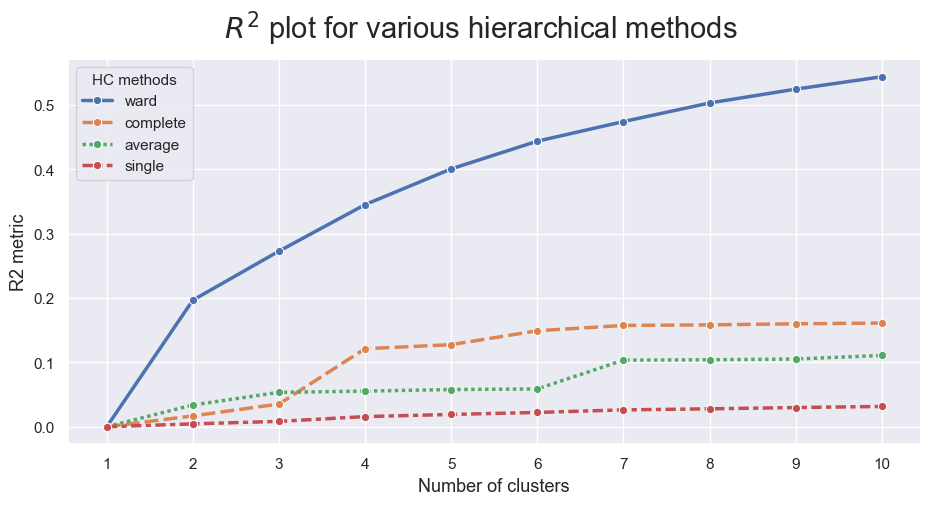

In [67]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

- We can see in the figure above that ward outperforms all other linkage methods, so it will be the one used.

__`Step 39`__ Perform hierarchical clustering without limitation of clusters to check the dendrogram.

In [68]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(perspective1)

array([16375, 30930, 30853, ...,     6,     2,     0], dtype=int64)

__`Step 39.1`__ Calculating Cluster Sizes and Building the Linkage Matrix for Hierarchical Clustering.

In [69]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

__`Step 39.2`__ Ploting the dendrogram.

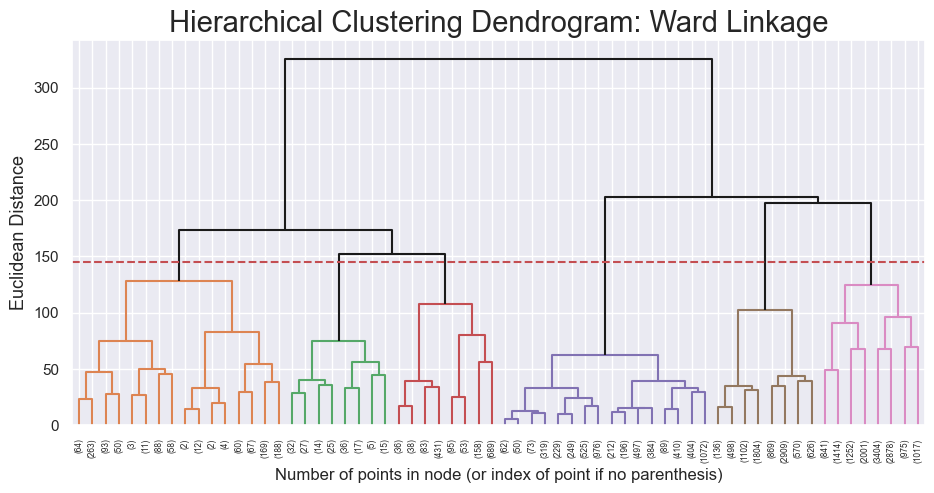

In [70]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 145
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

- By looking at the dendrogram we decided to go with 6 clusters as there would be large distances between the observations if we considered a clustering solution with less number of clusters and therefore would be a worse solution since clusters wouldn't be so homogeneous.

__`Step 40`__ Performing hierarchical clustering with 6 clusters.

In [71]:
# 6 cluster solution
n_clusters = 6

hc4_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc4_labels = hc4_clust.fit_predict(perspective1)

__`Step 40.1`__ Pass the results of the clustering to a dataframe.

In [72]:
df_concat3 = pd.concat([perspective1, 
                       pd.Series(hc4_labels, 
                                 name='labels', 
                                 index=perspective1.index)], 
                    axis=1)

df_concat3.groupby('labels').mean()

Orders_Weekday  Orders_Weekend  Early_Morning   Morning  Afternoon  \
labels                                                                       
0             1.611342        1.338370       2.322821  0.642278   0.336518   
1             0.040950        0.084440      -0.017275 -0.066802   0.057222   
2             6.359653        5.737685       1.404845  5.688904   4.905466   
3            -0.465419       -0.478108      -0.153587 -0.267999  -0.383032   
4             2.019317        1.551788      -0.015994  1.782371   1.887701   
5            -0.486752       -0.369161      -0.241509 -0.240459  -0.310111   

         Evening     Night   dayswus   recency  
labels                                          
0       0.121038  2.795784  1.889464 -0.749634  
1       0.117026  0.047388  1.489431 -0.403408  
2       4.844452  0.463453  2.193755 -0.967650  
3      -0.349027 -0.241996 -0.095498 -0.133349  
4       1.330474 -0.030552  1.975581 -0.818002  
5      -0.304885 -0.319206  1.681837  1.568924

#### Testing with feature Normalization

__`Step 41`__ Calculate the $R^2$ for the following linkage methods for hierarchical clustering: `ward`, `complete`, `average` and `single` for the dataset with features normalized.

In [73]:
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

r2_hc = np.vstack([get_r2_hc(perspective1_normalized, 
                              link,
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") 
                              for link in hc_methods])

__`Step 41.1`__ Convert the results into a Dataframe.

In [74]:
r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

__`Step 41.2`__ Plot the results.

In [75]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

- Based on the graph we can see that using *single* or *ward* methods provide more or less the same results for solutions with 4 or less clusters, but ward because the best with more tha 4 clusters so it will be used as linkage method.

__`Step 42`__ Perform hierarchical clustering without limitation of clusters to check the dendrogram.

In [76]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(perspective1_normalized)

array([22899, 30919, 21742, ...,     6,     2,     0], dtype=int64)

__`Step 42.1`__ Calculating Cluster Sizes and Building the Linkage Matrix for Hierarchical Clustering.

In [77]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

__`Step 42.2`__ Ploting the dendrogram.

In [78]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 50
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

- Based on the dendrogram, it was decided to go with 4 clusters, since distance between points only start to get very big if we use solutions with less than 4 clusters.

__`Step 43`__ Performing hierarchical clustering with 4 clusters.

In [79]:
# 4 cluster solution
n_clusters = 4

hc4_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc4_labels2 = hc4_clust.fit_predict(perspective1_normalized)

__`Step 43.1`__ Pass the results of the clustering to a dataframe.

In [80]:
# Characterizing the 4 clusters
df_concat4 = pd.concat([perspective1_normalized, 
                       pd.Series(hc4_labels2, 
                                 name='labels', 
                                 index=perspective1_normalized.index)], 
                    axis=1)

df_concat4.groupby('labels').mean()

Orders_Weekday  Orders_Weekend  Early_Morning   Morning  Afternoon  \
labels                                                                       
0             0.346427        0.644012       0.539778  0.190551   0.058528   
1             0.472676        0.742252       0.449224  0.190551   0.999994   
2             0.726657        0.888111       0.542659  0.999986   0.999995   
3             0.449241        0.738336       0.546004  0.999985   0.058528   

         Evening     Night   dayswus   recency  
labels                                          
0       0.725303  0.640608  0.386745  0.622132  
1       0.693749  0.479995  0.472847  0.527082  
2       0.732999  0.528291  0.630798  0.368102  
3       0.555085  0.557391  0.450768  0.541018

__`Step 44`__ Make a contigency table of the 4 clusters solution with the 7 cluster solution.

In [81]:
# Creating a contingency table
contingency_table = pd.crosstab(hc4_labels, hc4_labels2, colnames=['4 Clusters'], rownames=['6 Clusters'])

# Display the contingency table
print("Contingency Table for 6 Clusters vs. 4 Clusters:")
print(contingency_table)

Contingency Table for 6 Clusters vs. 4 Clusters:
4 Clusters     0     1     2     3
6 Clusters                        
0            190   206   501   237
1           2565  4846  4158  2213
2              1     5   163     2
3           2949  2837   747  1981
4             14   226  1235   108
5           1549  2105   802  1291


**Insights from the Contingency Table**

1. **The 6 cluster solution has a high cluster imbalance**
    In the 6 cluster solution we can see that while we have clusters like number 1 that has a lot of observations (**13782**) it also has others like numbers 0 and 2 with very few observations (**1134 and 171 respectively**), which will make this solution not very good because it is putting a lot of people in one single cluster that have different behaviours as we can see since they spread out in the 4 clustr solution.
2. **The 4 cluster solution does not present a high cluster imbalance**
    We can see that the majority of the clusters have the same size, which makes it better than the 6 cluster solution that is capturing some niche behaviour like in cluster number 2.

**Overall the 4 cluster solution is a better clustering solution that the 6 cluster solution.**

__`Step 44.1`__ Make a contigency table of the K-Means vs the Hierarchical Clustering solution.

In [82]:
# Creating a contingency table
contingency_table = pd.crosstab(labels2, hc4_labels2, colnames=['4 Clusters'], rownames=['4 Clusters'])

# Display the contingency table
print("Contingency Table for 4 Clusters vs. 4 Clusters:")
print(contingency_table)

Contingency Table for 4 Clusters vs. 4 Clusters:
4 Clusters     0      1     2     3
4 Clusters                         
0              0  10221     0     0
1              0      0     0  5832
2              0      4  7606     0
3           7268      0     0     0


**Insights from the Contingency Table**

1. **Overall the solutions are very similar**
    The 4 cluster solutions form K-Means and the one from the hierarchical have the same number of cluster so using one or another is very similar in terms of profiling. However while the numbers of clusters is the same the solutions can be different, but in the end of the day they provide us with a similar way to segment ABCDEats Inc. customers.


**We decided to go with K-Means solution since K-Means is a faster algorithm and can reasign observations to different clusters (the observations are not fixed eternaly to 1 cluster)**


### 6.1.3. Visualizing the Clustering Solution

__`Step 45`__ Using t-sne to visualize the KMeans solution for the customer_activity perspective.

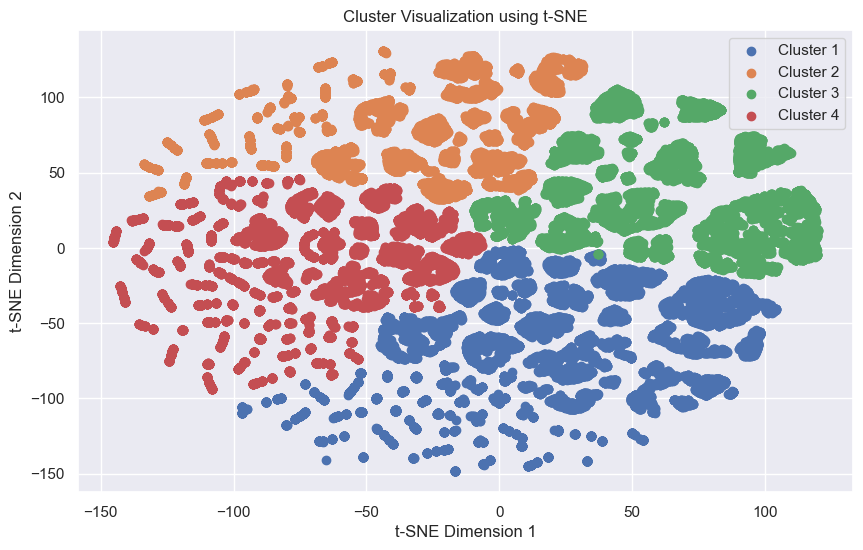

In [83]:
# Reduce data to 2 dimensions
tsne = TSNE(n_components=2, random_state=90)
perspective1_tsne = tsne.fit_transform(perspective1_normalized)

# Visualize the clusters in 2D
plt.figure(figsize=(10, 6))
for i in range(4):
    cluster_points = perspective1_tsne[labels2 == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}')

plt.title('Cluster Visualization using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)

# Save the image
plt.savefig('cluster_visualization_tsne_p1.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

- We can see from t-SNE a good separation of the clusters indicating we have a good clustering solution.

## 6.2. Cuisine Preferences Perspective

__`Step 46`__ Create a subset called `perspective2` that store the information regarding the cuisine preferences for clustering.

In [84]:
perspective2 = scaled_df[cuisine_preferences]

# Checking the number of rows and columns from the new created dataframe 
perspective2.shape

(30931, 11)

### 6.2.1. Using KMeans

__`Step 47`__ Visualise the within-cluster sum of squares (WSS) for different cluster amounts of `perspective2` to determine the optimal amount of clusters for our data, also known as the elbow method

In [85]:
def plot_elbow_graph(data, max_clusters=10):
    # List to store the WSS (Within-Cluster Sum of Squares)
    wss = []
    
    # Iterate through a range of clusters
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=15, random_state = 90)
        kmeans.fit(data)
        wss.append(kmeans.inertia_)
    
    # Plot the elbow graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters+1), wss, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WSS)')
    plt.grid(True)
    plt.show()

plot_elbow_graph(perspective2)

- There is not a very clear elbow for the clustering solution, since the inertia seems very linear.

__`Step 48`__ Use the average silhouette score to see what is the best clustering solution

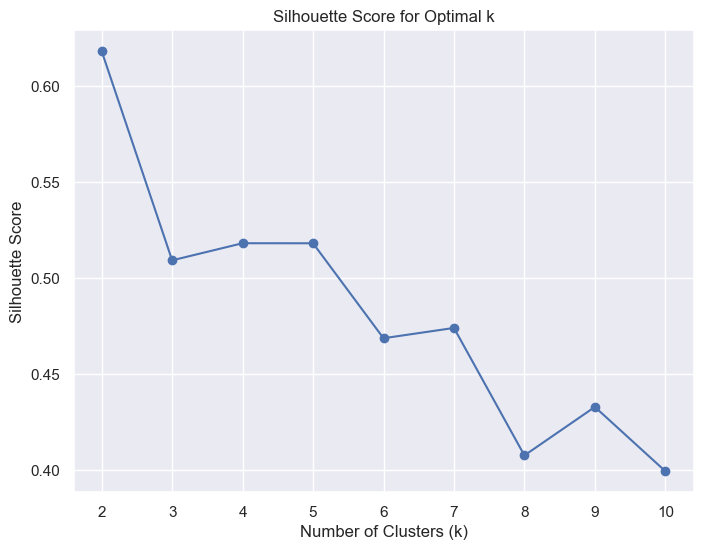

In [86]:
# Compute the silhouette score for a range of k values
sil_scores = []
for k in range(2,11): 
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=15, random_state=90)
    kmeans.fit(perspective2)
    sil_score = silhouette_score(perspective2, kmeans.labels_)
    sil_scores.append(sil_score)

# Plot the Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range(2,11), sil_scores, marker='o', color='b')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

**Choice in the number of clusters**

- Inertia (Scree Plot) - Inconclusive
- Silhouette score - 2 clusters

**Final Decision:** 2 clusters

__`Step 49`__ Perform the KMeans with 2 clusters.

In [87]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=15, random_state=90)
labels3 = kmeans.fit_predict(perspective2)

__`Step 49.1`__ Print the centroids of the clustering solution

In [88]:
Centroids = pd.DataFrame(kmeans.cluster_centers_.round(2), columns=perspective2.columns)

# Print the DataFrame
print(tabulate(Centroids, headers='keys', tablefmt='pretty', showindex=True))
stats = Centroids.describe().iloc[[1,2,3,7]]
minmax_diff = stats.iloc[3]-stats.iloc[2]
stats.loc['minmax_differences'] = minmax_diff
print(stats)

+---+-----------+----------+-------------+--------------+-------------+--------------+-------------------+-----------+-------------------+-------------+---------------------------+
|   | CUI_Asian | CUI_Cafe | CUI_Chinese | CUI_Desserts | CUI_Healthy | CUI_Japanese | CUI_Noodle Dishes | CUI_OTHER | CUI_IndianOceanic | CUI_Western | CUI_Street_Food_Beverages |
+---+-----------+----------+-------------+--------------+-------------+--------------+-------------------+-----------+-------------------+-------------+---------------------------+
| 0 |   0.07    |   1.25   |    0.55     |    -0.06     |    0.83     |     0.76     |       0.17        |    2.1    |       1.75        |    1.75     |           -0.15           |
| 1 |   -0.01   |  -0.07   |    -0.03    |     0.0      |    -0.05    |    -0.04     |       -0.01       |   -0.12   |       -0.1        |    -0.1     |           0.01            |
+---+-----------+----------+-------------+--------------+-------------+--------------+---------

#### Testing with feature Normalization

__`Step 50`__ Create a copy of the first perspective.

In [89]:
perspective2_normalized = perspective2.copy()

__`Step 51`__ Perform the Johnson SU transformation on the data.

In [90]:
# Apply the Johnson transformation to all numeric columns
for column in perspective2_normalized.select_dtypes(include=[np.number]).columns:
    perspective2_normalized[column] = johnson_transform(perspective2_normalized[column])

__`Step 52`__ Visualise the within-cluster sum of squares (WSS) for different cluster amounts of `perspective2` to determine the optimal amount of clusters for our data, also known as the elbow method

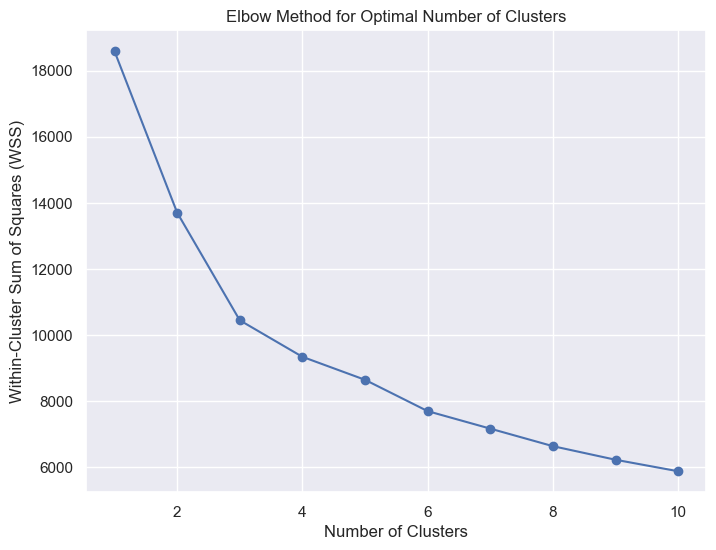

In [91]:
def plot_elbow_graph(data, max_clusters=10):
    # List to store the WSS (Within-Cluster Sum of Squares)
    wss = []
    
    # Iterate through a range of clusters
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=15, random_state = 90)
        kmeans.fit(data)
        wss.append(kmeans.inertia_)
    
    # Plot the elbow graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters+1), wss, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WSS)')
    plt.grid(True)
    plt.show()

plot_elbow_graph(perspective2_normalized)

- The elbows seems to lay in the 3 clusters.

__`Step 53`__ Use the average silhouette score just to confirm that 7 is a good solution

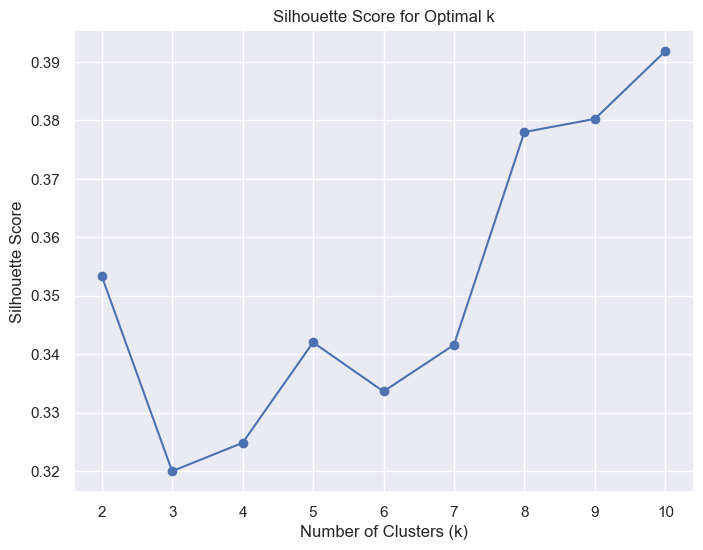

In [92]:
# Compute the silhouette score for a range of k values
sil_scores = []
for k in range(2,11): 
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=15, random_state=90)
    kmeans.fit(perspective2_normalized)
    sil_score = silhouette_score(perspective2_normalized, kmeans.labels_)
    sil_scores.append(sil_score)

# Plot the Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range(2,11), sil_scores, marker='o', color='b')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

**Choice in the number of clusters**

- Inertia (Scree Plot) - 3 clusters
- Silhouette score - 10 clusters

**Final Decision:** 10 clusters (due to the difference in the silhouette scores)

__`Step 54`__ Perform KMeans with 10 clusters.

In [93]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=15, random_state=90)
labels4 = kmeans.fit_predict(perspective2_normalized)

__`Step 54.1`__ Check the centroids of the clustering solution

In [94]:
Centroids = pd.DataFrame(kmeans.cluster_centers_.round(2), columns=perspective2_normalized.columns)

# Print the DataFrame
print(tabulate(Centroids, headers='keys', tablefmt='pretty', showindex=True))
stats = Centroids.describe().iloc[[1,2,3,7]]
minmax_diff = stats.iloc[3]-stats.iloc[2]
stats.loc['minmax_differences'] = minmax_diff
print(stats)

+---+-----------+----------+-------------+--------------+-------------+--------------+-------------------+-----------+-------------------+-------------+---------------------------+
|   | CUI_Asian | CUI_Cafe | CUI_Chinese | CUI_Desserts | CUI_Healthy | CUI_Japanese | CUI_Noodle Dishes | CUI_OTHER | CUI_IndianOceanic | CUI_Western | CUI_Street_Food_Beverages |
+---+-----------+----------+-------------+--------------+-------------+--------------+-------------------+-----------+-------------------+-------------+---------------------------+
| 0 |    1.0    |   0.29   |     0.5     |     0.58     |    0.51     |     0.01     |       0.31        |   0.37    |       0.52        |    0.24     |           0.77            |
| 1 |   0.46    |   0.31   |    0.51     |     0.56     |    0.51     |     0.01     |       0.32        |   0.37    |       0.57        |    0.96     |           0.71            |
| 2 |    1.0    |   0.31   |    0.51     |     0.58     |    0.52     |     0.01     |       0.

__`Step 55`__ Create a contigency table to check the differences between the solution with 2 and with 4 clusters.

In [95]:
# Creating a contingency table
contingency_table = pd.crosstab(labels3, labels4, rownames=['2 Clusters'], colnames=['10 Clusters'])

# Display the contingency table
print("Contingency Table for 2 Clusters vs. 4 Clusters:")
print(contingency_table)

Contingency Table for 2 Clusters vs. 4 Clusters:
10 Clusters     0     1     2     3     4     5     6    7     8     9
2 Clusters                                                            
0              14   191    83    39   176    15    50  426   148   542
1            5229  6127  2452  2752  1853  4052  1245  899  2607  2031


**Insights from the Contingency Table**

1. **The 2 cluster solution has a huge imbalance**
    As occurred in the previous perspective the 2 cluster solution is very generic and includes a lot of customers in one clusters and the remaining are assigned to the other one, so it is not a very good solution.
2. **The 10 cluster solution does not present a huge imbalance**
    Contrarly the 10 cluster solution did not present a huge imbalance in the clusters and seems to be a bit superior than the 2 cluster one allowing us to understand customers cuisine preferences which is the main goal of this perspective.
3. **The 10 cluster solution has to many clusters**
    While it is better than the 2 cluster solution, the 10 cluster solution presents to many clusters, since using this solution would create 40 different clusters in the profiling stage which is by no means ideal.


**While the 10 cluster solution was considered the best the 2 solutions are still not very good.**

### 6.2.2. Using Hierarchical Clustering

__`Step 56`__ Calculate the $R^2$ for the following linkage methods for hierarchical clustering: `ward`, `complete`, `average` and `single`.

In [96]:
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

r2_hc = np.vstack([get_r2_hc(perspective2, 
                              link,
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") 
                              for link in hc_methods])

__`Step 56.1`__ Convert the results into a Dataframe.

In [97]:
r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

__`Step 56.2`__ Plot the results.

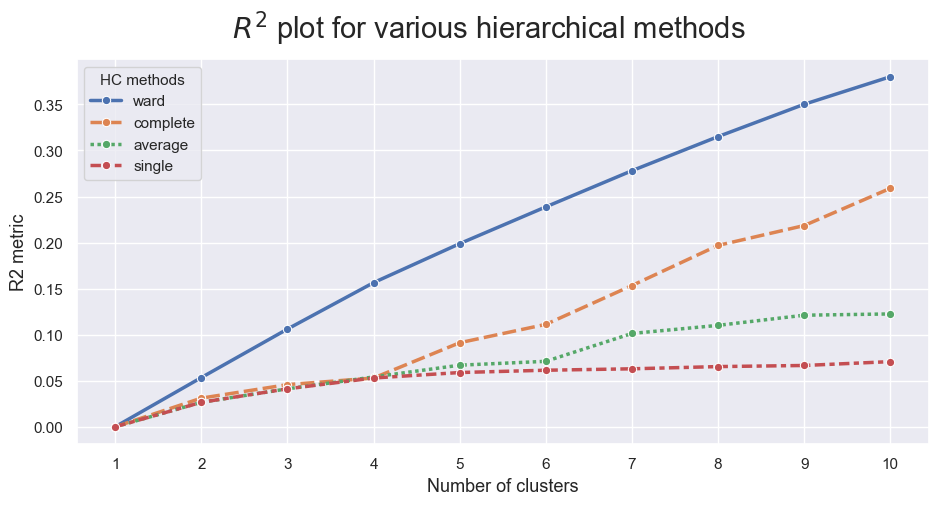

In [98]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

- We can see in the figure above that ward outperforms all other linkage methods, so it will be the one used.

__`Step 57`__ Perform hierarchical clustering without limitation of clusters to check the dendrogram.

In [99]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(perspective2)

array([19326, 26639, 27134, ...,     6,     2,     0], dtype=int64)

__`Step 57.1`__ Calculating Cluster Sizes and Building the Linkage Matrix for Hierarchical Clustering.

In [100]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

__`Step 57.2`__ Ploting the dendrogram.

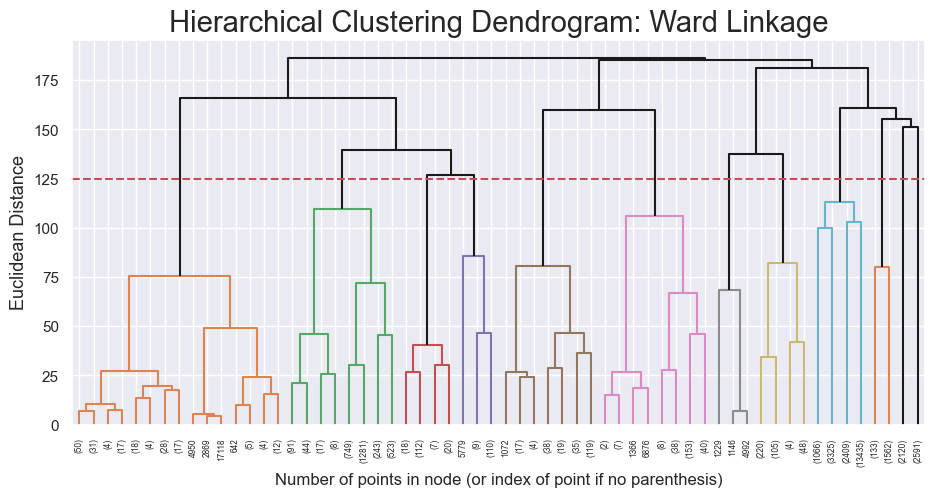

In [101]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 125
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

- The dendrogram indicates us to use 12 clusters for clustering.

__`Step 58`__ Performing hierarchical clustering with 12 clusters.

In [102]:
# 4 cluster solution
n_clusters = 12

hc4_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc4_labels3 = hc4_clust.fit_predict(perspective2)

__`Step 58.1`__ Check the centroids of the clustering solution.

In [103]:
# Characterizing the 4 clusters
df_concat3 = pd.concat([perspective2, 
                       pd.Series(hc4_labels3, 
                                 name='labels', 
                                 index=perspective2.index)], 
                    axis=1)

df_concat3.groupby('labels').mean()

CUI_Asian  CUI_Cafe  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
labels                                                                
0        4.421267 -0.045295    -0.041784      0.460191     0.305764   
1       -0.303360 -0.050591    -0.194665     -0.157325    -0.129985   
2       -0.033786 -0.074304    -0.115346     -0.034562    -0.042985   
3       -0.248959  0.069260    -0.092494     -0.140980    -0.011813   
4        0.196671 -0.120823    -0.164542     -0.039825    -0.147495   
5        0.033517  7.574366     0.087570     -0.138523     0.057823   
6        0.003467  0.935991    -0.184209     -0.031072     7.788557   
7       -0.070362 -0.056678    -0.174372     -0.158504    -0.114349   
8       -0.304567 -0.095402     0.418812     -0.113371    -0.098453   
9        0.589443 -0.109089    -0.046403      8.574103     0.007865   
10       0.566017  0.826033    55.751385     -0.167493    -0.163705   
11      -0.082686 -0.098493     2.636871     -0.118318    -0.139054   

        CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  CUI_IndianOceanic  \
labels                                                                  
0           4.080418          -0.156015  -0.131938          -0.021610   
1          -0.091559          -0.147143  -0.101696           2.300959   
2          -0.034152          -0.065934  -0.176004          -0.211019   
3          -0.034281          -0.095305   2.836707           0.131905   
4          -0.086046          -0.152806  -0.288659          -0.261528   
5           0.792101          -0.135100   0.985332           0.639369   
6           0.184053          -0.102526   0.562554           0.199308   
7          -0.086031          -0.154076   0.064797          -0.149168   
8          -0.081495           6.397036   0.303301          -0.046338   
9           0.004026          -0.140125  -0.229793          -0.269135   
10          2.447617          14.828397   4.051531           3.802118   
11         -0.023887           0.073233   0.270871           0.076024   

        CUI_Western  CUI_Street_Food_Beverages  
labels                                          
0          0.376889                   0.630283  
1          0.027324                  -0.306129  
2         -0.194774                  -0.237562  
3          0.078931                  -0.255950  
4         -0.278514                   2.103017  
5          1.252048                  -0.285567  
6          0.178887                  -0.098288  
7          2.619683                  -0.247153  
8         -0.313381                  -0.192977  
9         -0.010200                   0.728427  
10         0.341059                   0.580240  
11        -0.158700                  -0.155978

#### Testing using feature Normalization

__`Step 59`__ Calculate the $R^2$ for the following linkage methods for hierarchical clustering: `ward`, `complete`, `average` and `single`.

In [104]:
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

r2_hc = np.vstack([get_r2_hc(perspective2_normalized, 
                              link,
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") 
                              for link in hc_methods])

__`Step 59.1`__ Convert the results into a Dataframe.

In [105]:
r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

__`Step 59.2`__ Plot the results.

In [106]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

- For solutions up to 2 clusters all linkage methods have the same performance, but *ward* becames the best for solutions with more than 2 clusters so it will be used as linkage method.

__`Step 60`__ Perform hierarchical clustering without limitation of clusters to check the dendrogram.

In [107]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(perspective2_normalized)

array([30930, 16670, 24579, ...,     1,     2,     0], dtype=int64)

__`Step 60.1`__ Calculating Cluster Sizes and Building the Linkage Matrix for Hierarchical Clustering.

In [108]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

__`Step 60.2`__ Ploting the dendrogram.

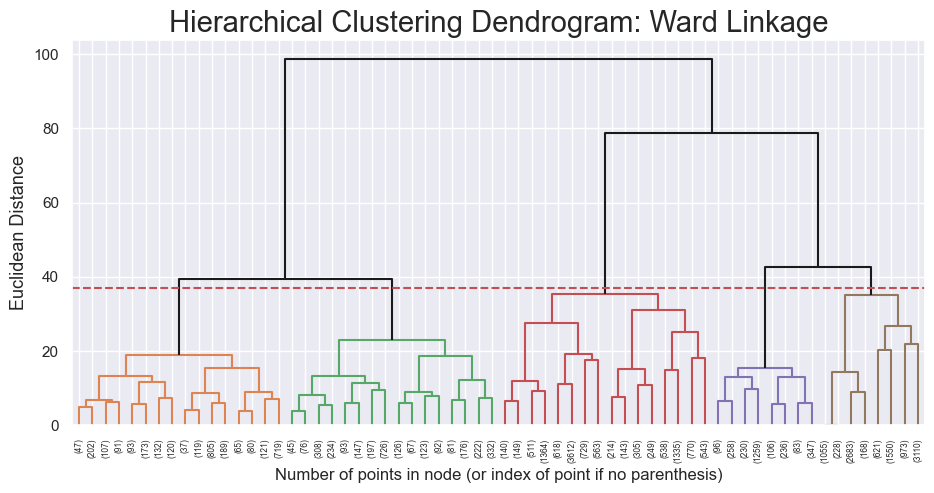

In [109]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 37
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

- The dendrogram indicates us to use a 5 cluster solution, nonetheless we could still use a a 3 or 4 cluster solution we decided to go with 5 to avoid having a cluster with to many observations.

__`Step 61`__ Performing hierarchical clustering with 5 clusters.

In [110]:
# 4 cluster solution
n_clusters = 5

hc4_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc4_labels4 = hc4_clust.fit_predict(perspective2_normalized)

__`Step 61.1`__ Checking the centroids of the clusters.

In [111]:
# Characterizing the 4 clusters
df_concat3 = pd.concat([perspective2_normalized, 
                       pd.Series(hc4_labels4, 
                                 name='labels', 
                                 index=perspective2_normalized.index)], 
                    axis=1)

df_concat3.groupby('labels').mean()

CUI_Asian  CUI_Cafe  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
labels                                                                
0        0.616255  0.339069     0.535351      0.565968     0.519024   
1        0.732264  0.283688     0.550933      0.582374     0.522296   
2        0.694187  0.379667     0.586723      0.577759     0.542025   
3        0.564174  0.283688     0.609430      0.563557     0.513380   
4        0.670319  0.283688     0.553514      0.572757     0.523027   

        CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  CUI_IndianOceanic  \
labels                                                                  
0           0.005582           0.333307   0.512476           0.583246   
1           0.005582           0.340411   0.368868           0.564435   
2           1.000000           0.363237   0.567345           0.603352   
3           0.005582           0.379772   1.000000           0.591676   
4           1.000000           0.350689   0.485906           0.547644   

        CUI_Western  CUI_Street_Food_Beverages  
labels                                          
0          0.935006                   0.728858  
1          0.236190                   0.791895  
2          0.933114                   0.755302  
3          0.236190                   0.724176  
4          0.236190                   0.743832

|**Cluster Number** |        **Cluster Label**        |
|-------------------|---------------------------------|
|         0         |      Western Cuisine Lovers     |
|         1         |  Asian Street Food Enthusiasts  |
|         2         |    Japano-Western Fusion Fans   |
|         3         |       Diverse Food Explorers    |
|         4         |        Sushi & Beyond Lovers    |

**Clustering Insights**

- "Western Cuisine Lovers" have as preference to buy Western food and don't enjoy much Eastern food since they don't order much of Japanese nor of Noodle Dishes.
- "Asian Street Food Enthusiasts" have a preference on Asian and street food and beverages.
- "Japano-Western Fusion Fans" purchase a lot of Japanese and Western food, but also purchase a fair amount of Asian food.
- "Diverse Food Explorers" buy mainly other types of food, so they enjoy to explore different cuisine types.
- "Sushi & Beyond Lovers" buy mainly Japanese food and Asian food to some extent.

__`Step 62`__ Make a contigency table of the 4 clusters solution with the 7 cluster solution.

In [112]:
# Creating a contingency table
contingency_table = pd.crosstab(hc4_labels3, hc4_labels4, colnames=['5 Clusters'], rownames=['12 Clusters'])

# Display the contingency table
print("Contingency Table for 5 Clusters vs. 12 Clusters:")
print(contingency_table)

Contingency Table for 5 Clusters vs. 12 Clusters:
5 Clusters      0     1     2     3     4
12 Clusters                              
0              56    44    96     2    79
1             891   788   199   108   134
2            7501  6808  1758  1784  2384
3             565     0   172   500    80
4             497  2033   186    30   210
5             160     0    90     0     0
6              82    75    48     8    20
7            1456     0   239     0     0
8             104   129    48    58    38
9              55   100    22     1    16
10              1     1     1     0     0
11            415   410   186   124   139


**Insights from the Contingency Table**

1. **The 12 cluster solution have clusters of outliers**
    The 12 cluster solution has a cluster with only 3 observations which most probably represnet clusters of outliers.
2. **The 12 cluster solution has to many clusters**
    One of the major issues with the 12 cluster solution is that for effects of profiling it would require us to analyze 48 different clusters which is fairly tidious and time/money consuming making it not a very good clustering solution.
3. **Neither of the clustering solutions seems to present huge cluster imbalances**
    Disregarding the cluster of outliers in the 12 cluster solution both s0lutions do not appear to have huge imbalances has we saw in the 2 cluster solution in the K-Means, but nonetheless the 5 cluster solution is superior becuase with less clusters allows us to do a good profiling of the clusters as intended.

**With all this said and done the 5 cluter solution is the superior clustering solution.**

__`Step 63`__ Compare the K-Means solution with the Hierarchical clustering solution.

In [113]:
# Creating a contingency table
contingency_table = pd.crosstab(labels4, hc4_labels4, colnames=['5 Clusters'], rownames=['10 Clusters'])

# Display the contingency table
print("Contingency Table for 10 Clusters vs. 5 Clusters:")
print(contingency_table)

Contingency Table for 10 Clusters vs. 5 Clusters:
5 Clusters      0     1     2     3     4
10 Clusters                              
0              42  5201     0     0     0
1            6318     0     0     0     0
2            2535     0     0     0     0
3               0     0    55     0  2736
4               0     0  2029     0     0
5             154  3913     0     0     0
6              38  1257     0     0     0
7               0     0   961     0   364
8             123    17     0  2615     0
9            2573     0     0     0     0


**Insights from the Contingency Table**

1. **The 5 cluster solution provides us a superior solution with half the clusters**
    The KMeans solution with 5 clusters has all the previously stated issues, and is worse than the 5 cluster solution since we need to analyse the double of the number of clusters and does not bring that much diversity in terms of preferances in cuisines of what should be expected from a solution with so many clusters so the hierarchical clustering solution proves to be the best clustering solution.

**The Hierarchical Clustering solution will be the one used in this perspective.**


### 6.2.3. Final solution visualization

__`Step 64`__ Using t-sne to visualize the Hierarchical clustering solution for the cusine_preferences perspective.

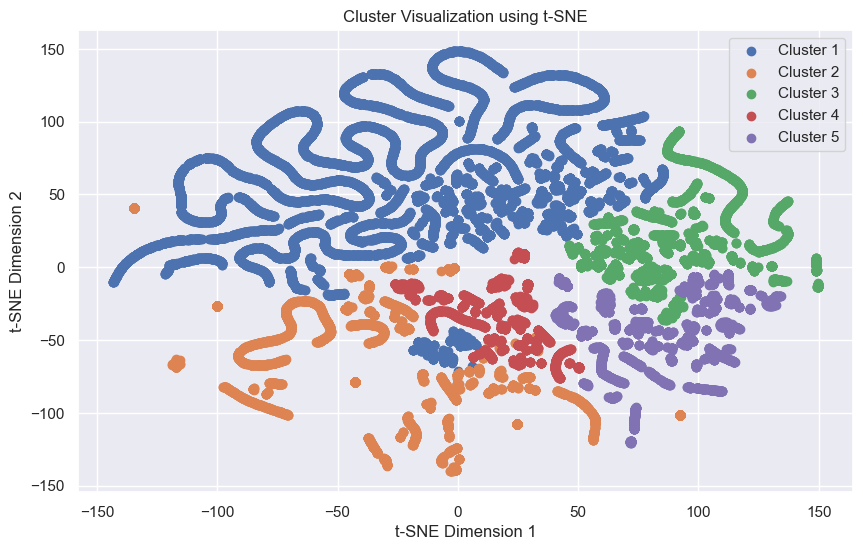

In [114]:
# Reduce data to 2 dimensions
tsne = TSNE(n_components=2, random_state=90)
perspective2_tsne = tsne.fit_transform(perspective2_normalized)

# Visualize the clusters in 2D
plt.figure(figsize=(10, 6))
for i in range(5):
    cluster_points = perspective2_tsne[hc4_labels4 == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}')

plt.title('Cluster Visualization using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()